# Amex Campus Challenge 2025
ML pipeline for predicting click probabilities based on customer, offer, event, and transaction data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [2]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 📁 Load Datasets
train_df = pd.read_parquet("Datasets/train_data.parquet")
test_df = pd.read_parquet("Datasets/test_data.parquet")
events_df = pd.read_parquet("Datasets/add_event.parquet")
trans_df = pd.read_parquet("Datasets/add_trans.parquet")                
offers_df = pd.read_parquet("Datasets/offer_metadata.parquet")



In [3]:
print("Train Data", train_df.columns.tolist())
print("Test Data", test_df.columns.tolist())
print("Events Data", events_df.columns.tolist())
print("Transactions Data", trans_df.columns.tolist())
print("Offers Data", offers_df.columns.tolist())

Train Data ['id1', 'id2', 'id3', 'id4', 'id5', 'y', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 

In [4]:
# Check first few rows and datatypes
print("Train:\n", train_df.head())
print(train_df.dtypes)

print("Test:\n", test_df.head())
print(test_df.dtypes)

print("Events:\n", events_df.head())
print(events_df.dtypes)

print("Transactions:\n", trans_df.head())
print(trans_df.dtypes)

print("Offers:\n", offers_df.head())
print(offers_df.dtypes)


Train:
                                                id1      id2        id3  \
0  1366776_189706075_16-23_2023-11-02 22:22:00.042  1366776  189706075   
1      1366776_89227_16-23_2023-11-01 23:51:24.999  1366776      89227   
2      1366776_35046_16-23_2023-11-01 00:30:59.797  1366776      35046   
3    1366776_6275451_16-23_2023-11-02 22:21:32.261  1366776    6275451   
4      1366776_78053_16-23_2023-11-02 22:21:34.799  1366776      78053   

                       id4         id5  y   f1    f2    f3    f4  ...  f357  \
0  2023-11-02 22:22:00.042  2023-11-02  0  1.0  None  None  None  ...  None   
1  2023-11-01 23:51:24.999  2023-11-01  0  1.0  None  None  None  ...  None   
2  2023-11-01 00:30:59.797  2023-11-01  0  1.0  None  None  None  ...  None   
3  2023-11-02 22:21:32.261  2023-11-02  0  1.0  None  None  None  ...  None   
4  2023-11-02 22:21:34.799  2023-11-02  0  1.0  None  None  None  ...  None   

      f358 f359  f360   f361 f362               f363    f364 f365  \
0  

In [5]:
# 🚀 Rename columns in train dataset
train_df.rename(columns={
    'id1': 'interaction_id',             # optional
    'id2': 'customer_id',
    'id3': 'offer_id',
    'id4': 'impression_timestamp',
    'id5': 'impression_date',            # optional
    'y':   'click'
}, inplace=True)

# 🚀 Rename columns in test dataset
test_df.rename(columns={
    'id1': 'interaction_id',             # optional
    'id2': 'customer_id',
    'id3': 'offer_id',
    'id4': 'impression_timestamp',
    'id5': 'impression_date'             # optional
}, inplace=True)

# 🚀 Rename columns in offers dataset
offers_df.rename(columns={
    'id3':  'offer_id',
    'id9':  'offer_type',
    'f375': 'offer_code_type',
    'f376': 'offer_discount_value',
    'f377': 'offer_flag',
    'id10': 'offer_group',
    'id11': 'offer_metadata_flag',
    'f378': 'offer_extra_flag',
    'id12': 'offer_start',
    'id13': 'offer_end'
}, inplace=True)

# 🚀 Rename columns in events dataset
events_df.rename(columns={
    'id2': 'customer_id',
    'id3': 'offer_id',
    'id4': 'impression_timestamp',
    'id6': 'event_type',
}, inplace=True)

# 🚀 Rename columns in transactions dataset
trans_df.rename(columns={
    'id2': 'customer_id',
    'f367': 'transaction_amount',
    'f368': 'merchant_category',
    'f369': 'transaction_type',
    'f370': 'transaction_date',
    'f371': 'transaction_time_only',
    'f372': 'transaction_ym',
    'id8':  'region_flag',
    'f374': 'shared_offer_flag'
}, inplace=True)

# ⏳ Create full transaction datetime
trans_df['transaction_time'] = pd.to_datetime(
    trans_df['transaction_date'] + ' ' + trans_df['transaction_time_only'],
    errors='coerce'
)


In [6]:
#still the offerid column has str values in offer dataset and int32 values in train/test dataset
train_df['offer_id'] = train_df['offer_id'].astype(str)
test_df['offer_id'] = test_df['offer_id'].astype(str)
offers_df['offer_id'] = offers_df['offer_id'].astype(str)

In [7]:
# 1.🧩 Merge Offer Metadata
train_df = train_df.merge(offers_df, on='offer_id', how='left')
test_df = test_df.merge(offers_df, on='offer_id', how='left')



In [8]:
# 🕒 2. Convert timestamps to datetime
train_df['impression_timestamp'] = pd.to_datetime(train_df['impression_timestamp'])
test_df['impression_timestamp']  = pd.to_datetime(test_df['impression_timestamp'])
train_df['offer_start']          = pd.to_datetime(train_df['offer_start'])
test_df['offer_start']           = pd.to_datetime(test_df['offer_start'])
train_df['offer_end']            = pd.to_datetime(train_df['offer_end'])
test_df['offer_end']             = pd.to_datetime(test_df['offer_end'])

# 📆 3. Compute 'offer_age_days' — time since offer was launched
train_df['offer_age_days'] = (train_df['impression_timestamp'] - train_df['offer_start']).dt.days
test_df['offer_age_days']  = (test_df['impression_timestamp'] - test_df['offer_start']).dt.days

# 📆 4. Compute 'offer_time_to_expire' — time left until the offer ends
train_df['offer_time_to_expire'] = (train_df['offer_end'] - train_df['impression_timestamp']).dt.days
test_df['offer_time_to_expire']  = (test_df['offer_end'] - test_df['impression_timestamp']).dt.days

# 🕗 5. Extract hour of the day from impression timestamp
train_df['hour'] = train_df['impression_timestamp'].dt.hour
test_df['hour']  = test_df['impression_timestamp'].dt.hour

# 📅 6. Extract weekday (0=Mon, ..., 6=Sun)
train_df['weekday'] = train_df['impression_timestamp'].dt.weekday
test_df['weekday']  = test_df['impression_timestamp'].dt.weekday

# 🧘‍♂️ 7. Weekend flag (1 if Sat/Sun, else 0)
train_df['is_weekend'] = (train_df['weekday'] >= 5).astype(int)
test_df['is_weekend']  = (test_df['weekday'] >= 5).astype(int)

print(train_df.head())

                                    interaction_id customer_id   offer_id  \
0  1366776_189706075_16-23_2023-11-02 22:22:00.042     1366776  189706075   
1      1366776_89227_16-23_2023-11-01 23:51:24.999     1366776      89227   
2      1366776_35046_16-23_2023-11-01 00:30:59.797     1366776      35046   
3    1366776_6275451_16-23_2023-11-02 22:21:32.261     1366776    6275451   
4      1366776_78053_16-23_2023-11-02 22:21:34.799     1366776      78053   

     impression_timestamp impression_date click   f1    f2    f3    f4  ...  \
0 2023-11-02 22:22:00.042      2023-11-02     0  1.0  None  None  None  ...   
1 2023-11-01 23:51:24.999      2023-11-01     0  1.0  None  None  None  ...   
2 2023-11-01 00:30:59.797      2023-11-01     0  1.0  None  None  None  ...   
3 2023-11-02 22:21:32.261      2023-11-02     0  1.0  None  None  None  ...   
4 2023-11-02 22:21:34.799      2023-11-02     0  1.0  None  None  None  ...   

                        offer_extra_flag  \
0        g2baascbu

In [10]:
(events_df.head(20))

,customer_id,offer_id,event_type,impression_timestamp,id7
0,2431360,618619,Tiles,2023-10-22 08:08:17.768,None
1,2431360,363153,Tiles,2023-10-22 08:08:18.921,None
2,2431360,97193,Tiles,2023-10-22 08:08:17.765,None
3,2431360,654444,Tiles,2023-10-22 08:08:17.737,None
4,2431360,32325,Tiles,2023-10-22 08:08:17.812,None
5,2431360,34229,Tiles,2023-10-22 08:08:17.824,None
6,2202020,428865,Mobile_Timeline,2023-10-28 14:38:18.604,None
7,2202020,90904,Mobile_Timeline,2023-10-27 17:43:39.875,None
8,2202020,391491,Mobile_Timeline,2023-10-27 17:41:38.969,None
9,2202020,5254,Mobile_Timeline,2023-10-27 17:43:00.916,None


In [11]:
# Get all customer IDs used in train and test
relevant_customers = pd.concat([train_df['customer_id'], test_df['customer_id']]).unique()

# Filter events_df
events_df = events_df[events_df['customer_id'].isin(list(relevant_customers))]

In [12]:
(events_df.head(20))

,customer_id,offer_id,event_type,impression_timestamp,id7


In [15]:
s = train_df[train_df['customer_id'] == '2431360']
print(s)
print(train_df.shape)

Empty DataFrame
Columns: [interaction_id, customer_id, offer_id, impression_timestamp, impression_date, click, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20, f21, f22, f23, f24, f25, f26, f27, f28, f29, f30, f31, f32, f33, f34, f35, f36, f37, f38, f39, f40, f41, f42, f43, f44, f45, f46, f47, f48, f49, f50, f51, f52, f53, f54, f55, f56, f57, f58, f59, f60, f61, f62, f63, f64, f65, f66, f67, f68, f69, f70, f71, f72, f73, f74, f75, f76, f77, f78, f79, f80, f81, f82, f83, f84, f85, f86, f87, f88, f89, f90, f91, f92, f93, f94, ...]
Index: []

[0 rows x 388 columns]
(770164, 388)


In [33]:
# Recalculate features after filtering
event_feats = events_df.groupby('customer_id').agg(
    num_past_events=('offer_id', 'count'),
    unique_event_types=('event_type', 'nunique'),
    first_event_time=('impression_timestamp', 'min'),
    last_event_time=('impression_timestamp', 'max'),
    avg_event_hour=('impression_timestamp', lambda x: x.dt.hour.mean())
).reset_index()

event_feats['event_span_days'] = (event_feats['last_event_time'] - event_feats['first_event_time']).dt.days

event_type_counts = events_df.pivot_table(
    index='customer_id',
    columns='event_type',
    aggfunc='size',
    fill_value=0
).reset_index()

event_features = event_feats.merge(event_type_counts, on='customer_id', how='left')


In [34]:
print(event_features.head(20))

Empty DataFrame
Columns: [customer_id, num_past_events, unique_event_types, first_event_time, last_event_time, avg_event_hour, event_span_days]
Index: []


In [29]:
print("Train sample:", train_df['customer_id'].unique()[:5])
print("Events sample:", event_features['customer_id'].unique()[:5])

# Check overlap
print("Common customer_ids:", len(set(train_df['customer_id']).intersection(set(event_features['customer_id']))))


Train sample: [1366776 1370198 1372036 1375766 1377802]
Events sample: [2000001 2000002 2000003 2000004 2000005]
Common customer_ids: 0


In [27]:
train_df['customer_id'] = train_df['customer_id'].astype(int)
event_features['customer_id'] = event_features['customer_id'].astype(int)

train_df = train_df.merge(event_features, on='customer_id', how='left')


In [21]:
train_df = train_df.merge(event_features, on='customer_id', how='left')
test_df = test_df.merge(event_features, on='customer_id', how='left')


In [28]:
print("final_merged_train\n", train_df.head(100))

final_merged_train
                                      interaction_id  customer_id   offer_id  \
0   1366776_189706075_16-23_2023-11-02 22:22:00.042      1366776  189706075   
1       1366776_89227_16-23_2023-11-01 23:51:24.999      1366776      89227   
2       1366776_35046_16-23_2023-11-01 00:30:59.797      1366776      35046   
3     1366776_6275451_16-23_2023-11-02 22:21:32.261      1366776    6275451   
4       1366776_78053_16-23_2023-11-02 22:21:34.799      1366776      78053   
..                                              ...          ...        ...   
95     1370198_505879_16-23_2023-11-01 16:00:02.181      1370198     505879   
96     1370198_541344_16-23_2023-11-01 15:59:00.709      1370198     541344   
97      1370198_85905_16-23_2023-11-01 16:00:59.453      1370198      85905   
98       1370198_1398_16-23_2023-11-01 15:58:54.190      1370198       1398   
99      1370198_94938_16-23_2023-11-01 16:00:38.128      1370198      94938   

      impression_timestamp impr

In [13]:
# Ensure datetime conversion
trans_df['transaction_date'] = pd.to_datetime(trans_df['transaction_date'], errors='coerce')

# Group by customer_id for aggregations
trans_agg = trans_df.groupby('customer_id').agg(
    num_transactions=('transaction_amount', 'count'),
    total_transaction_amount=('transaction_amount', 'sum'),
    avg_transaction_amount=('transaction_amount', 'mean'),
    std_transaction_amount=('transaction_amount', 'std'),
    num_unique_merchants=('merchant_category', 'nunique'),
    num_transaction_types=('transaction_type', 'nunique'),
    first_transaction_date=('transaction_date', 'min'),
    last_transaction_date=('transaction_date', 'max'),
).reset_index()

# Compute recency (days since last transaction from impression time later)
trans_agg['transaction_span_days'] = (trans_agg['last_transaction_date'] - trans_agg['first_transaction_date']).dt.days

# One-hot encode transaction types per customer (optional, if useful)
txn_type_counts = trans_df.pivot_table(
    index='customer_id',
    columns='transaction_type',
    aggfunc='size',
    fill_value=0
).reset_index()
txn_type_counts.columns = ['customer_id'] + [f"txn_type_{col}" for col in txn_type_counts.columns[1:]]

# Final transaction features = merge both
transaction_features = trans_agg.merge(txn_type_counts, on='customer_id', how='left')


In [14]:
train_df['customer_id'] = train_df['customer_id'].astype(str)
transaction_features['customer_id'] = transaction_features['customer_id'].astype(str)

In [15]:
train_df = train_df.merge(transaction_features, on='customer_id', how='left')
test_df = test_df.merge(transaction_features, on='customer_id', how='left')


ALL NEW FEATURES HAVE BEEN CREATED FROM OFFERS , EVENTS , TRANSACTIONS DATA 

In [17]:
print("final_merged_train\n", train_df.head(20))

final_merged_train
                                      interaction_id customer_id   offer_id  \
0   1366776_189706075_16-23_2023-11-02 22:22:00.042     1366776  189706075   
1       1366776_89227_16-23_2023-11-01 23:51:24.999     1366776      89227   
2       1366776_35046_16-23_2023-11-01 00:30:59.797     1366776      35046   
3     1366776_6275451_16-23_2023-11-02 22:21:32.261     1366776    6275451   
4       1366776_78053_16-23_2023-11-02 22:21:34.799     1366776      78053   
5       1366776_31794_16-23_2023-11-02 22:21:32.333     1366776      31794   
6      1366776_664919_16-23_2023-11-01 23:51:25.022     1366776     664919   
7      1366776_481197_16-23_2023-11-02 22:21:46.374     1366776     481197   
8       1366776_78680_16-23_2023-11-02 22:21:03.978     1366776      78680   
9      1366776_960643_16-23_2023-11-02 22:22:55.276     1366776     960643   
10     1366776_156722_16-23_2023-11-02 22:22:55.192     1366776     156722   
11      1366776_97081_16-23_2023-11-02 22:21

In [ ]:
features = [
    'offer_type', 'offer_group', 'offer_discount_value',
    'offer_age_days', 'offer_time_to_expire',
    'hour', 'weekday', 'is_weekend', 
    # + any selected 'f' features like 'f1', 'f8', 'f20' (optional)
]

In [12]:
# transform catego into one-hot and numerical ko scale

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


categorical = ['offer_type', 'offer_group']
numerical = ['offer_discount_value', 'offer_age_days', 'offer_time_to_expire', 'hour', 'weekday', 'is_weekend']

# Add imputers before encoder/scaler
preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical),
    
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical)
])

In [13]:

X = train_df[categorical + numerical]
y = train_df['click']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = Pipeline([
    ('prep', preprocessor),
    ('lr', LogisticRegression(max_iter=200))
])

clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_val)[:, 1]


c:\Users\astit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
import numpy as np
import pandas as pd

def mapk(actual, predicted, k=7):
    """
    Computes the mean average precision at k.
    actual: dict of {customer_id: set(clicked_offer_id)}
    predicted: dict of {customer_id: [ranked offer_id list]}
    """
    score = 0.0
    for customer_id in actual:
        act = actual[customer_id]
        pred = predicted.get(customer_id, [])[:k]
        hits = 0.0
        avg_prec = 0.0
        for i, p in enumerate(pred):
            if p in act:
                hits += 1.0
                avg_prec += hits / (i + 1.0)
        if act:
            score += avg_prec / min(len(act), k)
    return score / len(actual)


Total clicks in val set: 000000001000100010000000000000100000000100000100000000000000000100000001000000000000000000000000000100000000000000000000001100000110000000000000000000000000000000000010000000000000100000000000000000100000000000000000000000000000000000000000000000000000000000100100000000000000000000000000010000000000000000000010000000000000000010000000000000000001000000000000001000000010000000000000000001000010000000000000000000000000000000000000000100010000000000010000000000000010000100000000000000000110000000010000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000010000000000000000000000000100000000000000100000000001000000000000000000000000000000010000000000000000000010000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000100000000000000000000001000000000000000000000000000000000000000000000000100000000000000000000001100000

Matplotlib is building the font cache; this may take a moment.


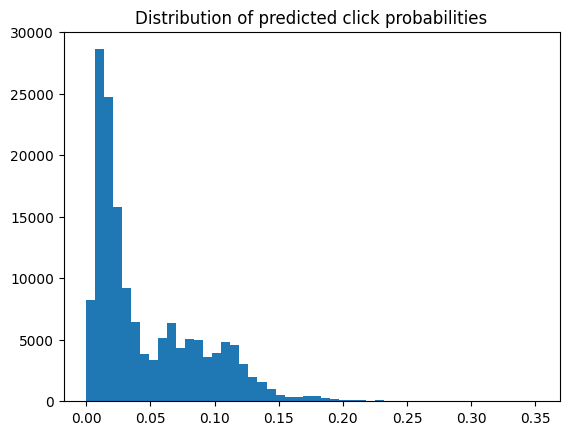

MAP@7: 0.0


In [18]:
# ✅ Step 1: Rebuild val_df with aligned index
val_df = X_val.copy()
val_df['click'] = y_val.values
val_df['click_proba'] = y_val_pred

# 🔍 Make sure customer_id and offer_id are aligned correctly using y_val index
val_df['customer_id'] = train_df.loc[y_val.index, 'customer_id'].values
val_df['offer_id'] = train_df.loc[y_val.index, 'offer_id'].values

# ✅ Step 2: Rank offers per customer
val_df['rank'] = val_df.groupby('customer_id')['click_proba'].rank(method='first', ascending=False)
top7 = val_df[val_df['rank'] <= 7]

# ✅ Step 3: Build actual and predicted offer dictionaries
actual = val_df[val_df['click'] == 1].groupby('customer_id')['offer_id'].apply(set).to_dict()
predicted = top7.sort_values(['customer_id', 'rank']) \
                .groupby('customer_id')['offer_id'].apply(list).to_dict()

# ✅ Step 4: Define safe MAP@7 function
def mapk(actual, predicted, k=7):
    if len(actual) == 0:
        return 0.0  # avoid division by zero

    score = 0.0
    for cust_id in actual:
        act = actual[cust_id]
        pred = predicted.get(cust_id, [])[:k]
        hits = 0.0
        avg_prec = 0.0
        for i, p in enumerate(pred):
            if p in act:
                hits += 1.0
                avg_prec += hits / (i + 1.0)
        score += avg_prec / min(len(act), k)
    return score / len(actual)

print("Total clicks in val set:", val_df['click'].sum())
for cid in list(actual.keys())[:5]:
    print(f"Customer: {cid}")
    print("Actual clicked:", actual[cid])
    print("Predicted top 7:", predicted.get(cid, []))
    print("----")


import matplotlib.pyplot as plt
plt.hist(y_val_pred, bins=50)
plt.title("Distribution of predicted click probabilities")
plt.show()


# ✅ Step 5: Evaluate
map_score = mapk(actual, predicted, k=7)
print("MAP@7:", round(map_score, 5))


In [ ]:
# 🧠 Add Event Features
events_df['impression_hour'] = pd.to_datetime(events_df['impression_timestamp']).dt.hour
event_features = events_df[['customer_id', 'offer_id', 'impression_hour']]

train_df = train_df.merge(event_features, on=["customer_id", "offer_id"], how="left")
test_df = test_df.merge(event_features, on=["customer_id", "offer_id"], how="left")

In [ ]:
# 💳 Add Transaction Features
trans_df['transaction_time'] = pd.to_datetime(trans_df['transaction_date'] + " " + trans_df['time_of_transaction'])

def get_transaction_features(df):
    df['impression_timestamp'] = pd.to_datetime(df['impression_timestamp'])
    features = []
    for _, row in df.iterrows():
        cid = row['customer_id']
        imp_time = row['impression_timestamp']
        cust_trans = trans_df[trans_df['customer_id'] == cid]
        past_trans = cust_trans[cust_trans['transaction_time'] < imp_time]
        total_spent = past_trans['transaction_amount'].sum()
        features.append(total_spent)
    df['total_spent_before'] = features
    return df

train_df = get_transaction_features(train_df)
test_df = get_transaction_features(test_df)

In [ ]:
# 🏋️ Train Model
features = [col for col in train_df.columns if col not in ['click', 'customer_id', 'offer_id', 'impression_timestamp']]
X = train_df[features]
y = train_df['click']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:, 1]
print("Validation Score (Average Precision):", average_precision_score(y_val, y_val_pred))

In [ ]:
# 🔮 Predict on Test Data
test_preds = model.predict_proba(test_df[features])[:, 1]
test_df['click_proba'] = test_preds

In [ ]:
# 🧾 Prepare Submission
test_df['rank'] = test_df.groupby('customer_id')['click_proba'].rank(method='first', ascending=False)
top_offers = test_df[test_df['rank'] <= 7]

submission = top_offers.sort_values(['customer_id', 'rank']) \
    .groupby('customer_id')['offer_id'].apply(list).reset_index()

submission['offer_id'] = submission['offer_id'].apply(lambda x: x + ['NA'] * (7 - len(x)) if len(x) < 7 else x)

# Save
submission[['customer_id', 'offer_id']].to_csv("r2_submission_file_1_teamname.csv", index=False)